# 🎨 Transfert de Style Neuronal avec VGG19
Ce notebook vous guide pas à pas à travers la mise en œuvre du **transfert de style neuronal** en utilisant PyTorch et un réseau **VGG19 pré-entraîné**.


## 📚 Table des matières
1. [Préparation de l'environnement](#setup)
2. [Chargement des images](#load)
3. [Définition des fonctions utiles](#utils)
4. [Définition du modèle](#model)
5. [Exécution du transfert de style](#transfer)
6. [Visualisation du résultat](#visual)


In [1]:
# 📦 Préparation de l'environnement
!pip install torch torchvision Pillow matplotlib numpy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# 🔧 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import os


In [3]:
# 📌 Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Utilisation du device : {device}")

🖥️ Utilisation du device : cpu


## 🖼️ Chargement des images
<a id='load'></a>

In [ ]:
# 🖼️ Fonction : load_image
# Charge une image, la redimensionne et la transforme en tenseur.
# Préparation indispensable pour toute image utilisée dans le modèle.

def load_image(image_path, imsize=512):
    transform = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
# 🖼️ Fonction : show_image
# Affiche une image à partir d’un tenseur PyTorch.
# Permet de visualiser le contenu, le style ou les résultats générés.

def show_image(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

## 📐 Fonctions utiles : Matrice de Gram
<a id='utils'></a>

In [ ]:
# 🧮 Fonction : gram_matrix
# Calcule la matrice de Gram d’une image pour capturer les corrélations de style.
# C’est l’élément clé dans l’analyse et le transfert de style.

def gram_matrix(input):
    batch_size, channels, height, width = input.size()
    features = input.view(batch_size * channels, height * width)
    G = torch.mm(features, features.t())
    return G.div(batch_size * channels * height * width)

## 🧠 Définition du modèle VGG19 modifié
<a id='model'></a>

In [ ]:
# ⚖️ Classe : Normalization
# Normalise les images selon les statistiques de VGG19.
# Cela garantit que les images ont la même distribution que celles du jeu ImageNet.

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)
    def forward(self, img):
        return (img - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
# 🧠 Fonction : get_style_model_and_losses
# Construit un modèle VGG19 modifié avec des modules pour calculer
# la perte de contenu et de style.
# Renvoie le modèle et les couches de pertes correspondantes.

def get_style_model_and_losses(c_img, s_img, 
                               content_layers=['conv_4'], 
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    vgg = models.vgg19(pretrained=True).features.to(device).eval()
    for param in vgg.parameters():
        param.requires_grad_(False)

    norm_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    norm_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    normalization = Normalization(norm_mean, norm_std).to(device)

    model = nn.Sequential(normalization)
    content_losses, style_losses = [], []
    conv_count = 0

    for layer in vgg.children():
        if isinstance(layer, nn.Conv2d):
            conv_count += 1
            name = f'conv_{conv_count}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{conv_count}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{conv_count}'
        else:
            continue

        model.add_module(name, layer)

        if name in content_layers:
            target = model(c_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{conv_count}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(s_img).detach()
            style_loss = StyleLoss(target)
            model.add_module(f"style_loss_{conv_count}", style_loss)
            style_losses.append(style_loss)

    return model, style_losses, content_losses

## 🔁 Lancer le transfert de style
<a id='transfer'></a>

In [ ]:
# 🖼️ Fonction : run_style_transfer
# Effectue l’optimisation pour transférer le style d’une image sur une autre.
# Minimise la combinaison pondérée des pertes de contenu et de style.

def run_style_transfer(content_img, style_img, input_img, steps=300, style_weight=1e6, content_weight=1):
    model, style_losses, content_losses = get_style_model_and_losses(content_img, style_img)
    input_img.requires_grad_(True)
    optimizer = torch.optim.LBFGS([input_img])

    run = [0]
    while run[0] <= steps:
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses) * style_weight
            content_score = sum(cl.loss for cl in content_losses) * content_weight
            loss = style_score + content_score
            loss.backward()
            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Étape {run[0]} : Style {style_score.item():.4f}, Contenu {content_score.item():.4f}")
            return loss
        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

## 🎨 Visualisation du résultat final
<a id='visual'></a>

c:\EXERCICES\deeplearning\venv3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\EXERCICES\deeplearning\venv3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\bouss/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth


100.0%


Étape 50 : Style 116.5676, Contenu 17.2249
Étape 100 : Style 41.3568, Contenu 16.1638
Étape 150 : Style 22.7539, Contenu 14.4123
Étape 200 : Style 12.3788, Contenu 13.2248
Étape 250 : Style 6.8274, Contenu 12.4243
Étape 300 : Style 4.0757, Contenu 11.6805


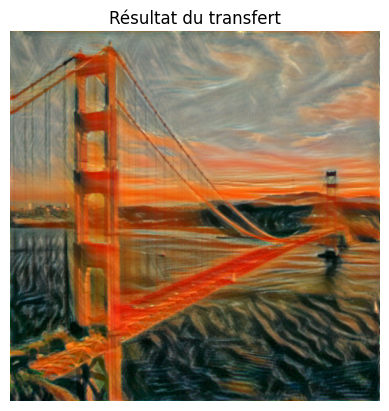

In [10]:
content = load_image("images/content1.jpg", imsize=512)
style = load_image("images/style1.jpg", imsize=512)
input_img = content.clone()

output = run_style_transfer(content, style, input_img, steps=300)
show_image(output, title="Résultat du transfert")



## 🔄 Approche inverse : extraire le contenu et le style depuis une image stylisée

Même si le transfert de style n’est **pas mathématiquement réversible**, on peut approximer :
- **le contenu** de l’image originale (formes, structure),
- **le style** (couleurs, textures) à travers les **matrices de Gram**.

In [ ]:
# 🔍 Fonction : extract_content_and_style_from_image
# Extrait les représentations internes de contenu et de style
# d’une image stylisée en utilisant VGG19.

def extract_content_and_style_from_image(image, content_layers=['conv_4'], style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    model = models.vgg19(pretrained=True).features.to(device).eval()
    content_features = {}
    style_grams = {}

    conv_count = 0
    x = image.clone()

    for layer in model.children():
        if isinstance(layer, nn.Conv2d):
            conv_count += 1
            name = f'conv_{conv_count}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{conv_count}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{conv_count}'
        else:
            continue

        x = layer(x)

        if name in content_layers:
            content_features[name] = x
        if name in style_layers:
            style_grams[name] = gram_matrix(x)

    return content_features, style_grams


In [12]:
content_feats, style_grams = extract_content_and_style_from_image(output)

print("Couches de contenu extraites :", list(content_feats.keys()))
print("Couches de style extraites :", list(style_grams.keys()))


Couches de contenu extraites : ['conv_4']
Couches de style extraites : ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


In [ ]:
# 🔄 Fonction : reconstruct_content_from_stylized
# Reconstruit une image en se basant uniquement sur les activations de contenu
# d’une image stylisée. Approximation de l’inversion du transfert de style.

def reconstruct_content_from_stylized(target_img, steps=300, content_layer='conv_4'):
    """
    Recrée une image qui a les mêmes activations de contenu que l'image stylisée.
    
    Args:
        target_img: Image stylisée (Tensor)
        steps: Nombre d'itérations d'optimisation
        content_layer: La couche VGG à utiliser comme référence de contenu
    
    Returns:
        Une image approximative du contenu original
    """
    vgg = models.vgg19(pretrained=True).features.to(device).eval()
    for param in vgg.parameters():
        param.requires_grad = False

    # Extraire la feature de contenu
    x = target_img.clone()
    conv_count = 0
    for layer in vgg.children():
        if isinstance(layer, nn.Conv2d):
            conv_count += 1
            name = f'conv_{conv_count}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{conv_count}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{conv_count}'
        else:
            continue

        x = layer(x)
        if name == content_layer:
            target_feature = x.detach()
            break

    # Image à reconstruire (bruit ou copie stylisée)
    reconstructed = torch.randn_like(target_img, requires_grad=True)
    optimizer = torch.optim.Adam([reconstructed], lr=0.01)

    for step in range(steps):
        optimizer.zero_grad()
        x = reconstructed
        conv_count = 0
        for layer in vgg.children():
            if isinstance(layer, nn.Conv2d):
                conv_count += 1
                name = f'conv_{conv_count}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu_{conv_count}'
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool_{conv_count}'
            else:
                continue
            x = layer(x)
            if name == content_layer:
                loss = F.mse_loss(x, target_feature)
                break

        loss.backward()
        optimizer.step()
        if step % 50 == 0:
            print(f"🔄 Étape {step} - perte de contenu : {loss.item():.4f}")

    with torch.no_grad():
        reconstructed.clamp_(0, 1)
    return reconstructed


c:\EXERCICES\deeplearning\venv3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\EXERCICES\deeplearning\venv3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔄 Étape 0 - perte de contenu : 87.8012
🔄 Étape 50 - perte de contenu : 23.5371
🔄 Étape 100 - perte de contenu : 11.3084
🔄 Étape 150 - perte de contenu : 6.9016
🔄 Étape 200 - perte de contenu : 4.5644
🔄 Étape 250 - perte de contenu : 3.0304


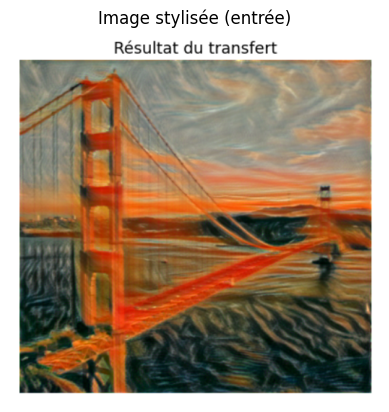

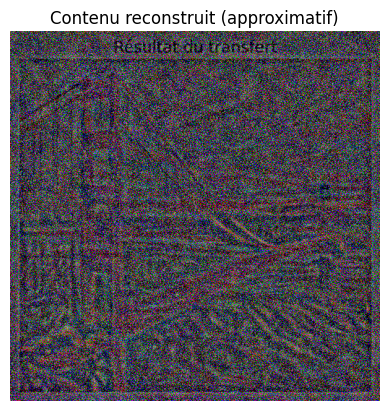

In [14]:
# Charger l'image stylisée (remplace le chemin si nécessaire)
stylized = load_image("images/output.png", imsize=512)

# Reconstitution du contenu
reconstructed = reconstruct_content_from_stylized(stylized, steps=300)

# Affichage du résultat
show_image(stylized, "Image stylisée (entrée)")
show_image(reconstructed, "Contenu reconstruit (approximatif)")
